In [ ]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import geopy
from tqdm import tqdm

import scipy.linalg as sla
import seaborn as sns
from sklearn.linear_model import LinearRegression as LR
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import HuberRegressor

In [ ]:
!pip install geopandas
!pip install geopy
!pip install contextily

In [ ]:
df_info = pd.read_excel('/content/Рестораны (2).xlsx')
df_numbers = pd.read_csv('/content/bquxjob_60790811_18d0f25161e.csv')

df_info = df_info.drop(['Последний тип ремоделинга', 'Код канала розничной торговли',
                        'Имя', 'Краткое наименование', 'JDE код', 'Номер магазина',
                        'Группа стран/регионов', 'Адрес', 'Эл. почта', 'Телефон',
                        'Статус', 'Статус workflow-процесса', 'WF-процессов',
                        'Последний тип ремоделинга', 'Последний год ремоделинга',
                        'Следующий тип ремоделинга', 'Следующий год ремоделинга',
                        'Расширение', 'Юридическое лицо франчайзи',
                        'Наименование юридического лица франчайзи'], axis=1)

df_info = df_info.rename(columns={'Внешний код Facts number': 'Fact ID',
                        'Цепочка компаний': 'Company Chain',
                        'Сабдивизион': 'Subdivision',
                        'Рынок сбыта': 'Market Segment',
                        'Ценовая группа': 'Price Group',
                        'WF-процессов': 'Workflow Processes',
                        'Тип помещения': 'Room Type'})

df_numbers = df_numbers.rename(columns = {'restraunt_id': 'Fact ID'})
df_numbers = df_numbers.drop(['tap_auth_count', 'tap_email_count', 'tap_sms_count'], axis=1)

geolocator = Nominatim(user_agent="nominatim.openstreetmap.org")
df_geo = pd.DataFrame(columns=['Market Segment', 'latitude', 'longitude'])

city_corrections = {
    'Moscow outside MKAD': 'Moscow',
    'Sholokhovo': 'Moscow',
    'Cherepovetc': 'Cherepovets',
    'Pavlovskaya Sloboda': 'Moscow',
    'Vsevolojsk': 'Saint Petersburg',
    'Beloozerskiy': 'Moscow',
    'Vnukovskoye': 'Moscow',
    'Mytischi': 'Moscow',
    'Tolliatty': 'Tolyatti',
    'Nizhniy Tagil': 'Nizhny Tagil',
    'Ozeretskoye': 'Moscow',
    'Novokuybishevsk': 'Samara',
    'Voljskiy': 'Volgograd',
    'Kamensk-Shakhtinskiy': 'Kamensk-Shakhtinsky'
}

for city in tqdm(df_info['Market Segment'].unique()):
    if city in city_corrections:
        city = city_corrections[city]

    city_copy = city

    if city in ['Barnaul', 'Sholokhovo', 'Orenburg', 'Moscow outside MKAD', 'Cherepovetc',
                   'Kemerovo', 'Pavlovskaya Sloboda', 'Vsevolojsk', 'Beloozerskiy', 'Kazan',
                   'Kazan', 'Vnukovskoye', 'Ufa', 'Tula', 'Engels', 'Moscow Region', 'Istra',
                   'Salavat', 'Mytischi', 'Tolliatty', 'Artyom', 'Nizhniy Tagil', 'Ozeretskoye',
                   'Suzdal', 'Marusino', 'Bratsk', 'Nazran', 'Derbent']:
        city += " Russia"

    location = geolocator.geocode(city)

    if location:
        data = {'Market Segment': city_copy, 'latitude': location.latitude, 'longitude': location.longitude}
        add = pd.DataFrame(data, index=[0])
        df_geo = pd.concat([df_geo, add], ignore_index=True)

print(df_geo)

df_info['Market Segment'] = df_info['Market Segment'].replace(city_corrections)

df = df_info.merge(df_geo, on='Market Segment', how='outer').drop_duplicates()
df = df.merge(df_numbers.groupby('Fact ID').agg({'action_order_success': 'sum', 'conversion_rate_total': 'mean'}), on='Fact ID', how='inner')

In [ ]:
price_groups = [
    "Стандарт+50%",
    "Стандарт+5%",
    "Стандарт+30%",
    "Стандарт+20%",
    "Стандарт+15%",
    "Стандарт+10%",
    "Стандарт",
    "Смартбокс+20%",
    "Смартбокс",
    "Сибирь"
]

data = df.copy()

for i in range(data['Fact ID'].count()):
  if data['Price Group'].iloc[i] not in price_groups:
    data['Price Group'].iloc[i] = 0

data = data.drop(['Subdivision', 'Company Chain'], axis=1)
data['Price Group'] = data['Price Group'].astype(str)


from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
data['Price Group'] = pd.DataFrame({"Price Group": labelencoder.fit_transform(data['Price Group'])})
data['Room Type'] = pd.DataFrame({"Room Type": labelencoder.fit_transform(data['Room Type'])})

<ipython-input-67-dea2fe562b6b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Price Group'].iloc[i] = 0


In [ ]:
# @title Препроцессинг
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

class Preproccess:
  def __init__(self, data):
    self.data = data

  # Преобразование нечисловых признаков
  def encoding(self):
    data = self.data.copy()
    dum = pd.get_dummies(data, drop_first=True)
    return dum

  def normalization(self):
    data = self.data.copy()
    normalizer = preprocessing.MinMaxScaler()
    real_norm_np = normalizer.fit_transform(data)
    data = pd.DataFrame(data=real_norm_np)

    return data

  def preprocess(self):
    self.data = self.encoding()
    self.data = self.normalization()
    return self.data

In [ ]:
data.head()

,Fact ID,Market Segment,Price Group,Room Type,latitude,longitude,action_order_success,conversion_rate_total,Cluster
0,74020442,Moscow,0,3,55.750541,37.617478,48335,0.763231,0
1,74020460,Moscow,0,4,55.750541,37.617478,3873,0.767060,0
2,74020477,Moscow,5,3,55.750541,37.617478,73563,0.684763,0
3,74020566,Moscow,0,0,55.750541,37.617478,10442,0.789830,0
4,74020588,Moscow,0,3,55.750541,37.617478,54841,0.814167,0


In [244]:
# Сопоставление номеров кластеров с цветами
# Исходный словарь цветов
cluster_colors = {
    0: 'gray', 1: 'darkred', 2: 'blue', 3: 'cadetblue', 4: 'black',
    5: 'lightgreen', 6: 'beige', 7: 'pink', 8: 'green', 9: 'darkpurple',
    10: 'lightgray', 11: 'darkblue', 12: 'orange', 13: 'red', 14: 'lightblue',
    15: 'lightred', 16: 'darkgreen', 17: 'white', 18: 'purple',
    19: 'gray', 20: 'darkred', 21: 'blue', 22: 'cadetblue', 23: 'black',
    24: 'lightgreen', 25: 'beige', 26: 'pink', 27: 'green', 28: 'darkpurple',
    29: 'lightgray', 30: 'darkblue', 31: 'orange', 32: 'red', 33: 'lightblue',
    34: 'lightred', 35: 'darkgreen', 36: 'white', 37: 'purple',
    38: 'gray', 39: 'darkred', 40: 'blue', 41: 'cadetblue', 42: 'black',
    43: 'lightgreen', 44: 'beige', 45: 'pink', 46: 'green', 47: 'darkpurple',
    48: 'lightgray', 49: 'darkblue', 50: 'orange', 51: 'red', 52: 'lightblue',
    53: 'lightred', 54: 'darkgreen', 55: 'white', 56: 'purple'
}

In [ ]:
# @title k mean (unactive)
# Выполните кластеризацию
k_means = KMeans(init="random", n_clusters=30, n_init='auto', algorithm='auto')
data['Cluster'] = k_means.fit_predict(data.iloc[:, 4:6])

# Сопоставление номеров кластеров с цветами
# Исходный словарь цветов
cluster_colors = {
    0: 'gray', 1: 'darkred', 2: 'blue', 3: 'cadetblue', 4: 'black',
    5: 'lightgreen', 6: 'beige', 7: 'pink', 8: 'green', 9: 'darkpurple',
    10: 'lightgray', 11: 'darkblue', 12: 'orange', 13: 'red', 14: 'lightblue',
    15: 'lightred', 16: 'darkgreen', 17: 'white', 18: 'purple',
    19: 'gray', 20: 'darkred', 21: 'blue', 22: 'cadetblue', 23: 'black',
    24: 'lightgreen', 25: 'beige', 26: 'pink', 27: 'green', 28: 'darkpurple',
    29: 'lightgray', 30: 'darkblue', 31: 'orange', 32: 'red', 33: 'lightblue',
    34: 'lightred', 35: 'darkgreen', 36: 'white', 37: 'purple',
    38: 'gray', 39: 'darkred', 40: 'blue', 41: 'cadetblue', 42: 'black',
    43: 'lightgreen', 44: 'beige', 45: 'pink', 46: 'green', 47: 'darkpurple',
    48: 'lightgray', 49: 'darkblue', 50: 'orange', 51: 'red', 52: 'lightblue',
    53: 'lightred', 54: 'darkgreen', 55: 'white', 56: 'purple'
}


# Создание базовой карты
m = folium.Map(location=[60, 100], zoom_start=3)

# Итерация по каждой строке датафрейма и добавление маркера на карту
for index, row in data.iterrows():
    cluster_color = cluster_colors[row['Cluster']]
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=f"{row[['Market Segment', 'Cluster', 'action_order_success']]} ({cluster_color})",
        icon=folium.Icon(color=cluster_color)
    ).add_to(m)

# Отображение карты
m

In [245]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=1, min_samples=5)
data['Cluster'] = clustering.fit_predict(data.iloc[:, 4:6])
data['Cluster'] = data['Cluster'][data['Cluster'] > -1]
data = data.dropna()


# Создание базовой карты
m = folium.Map(location=[60, 100], zoom_start=3)

# Итерация по каждой строке датафрейма и добавление маркера на карту
for index, row in data.iterrows():
    cluster_color = cluster_colors[row['Cluster']]
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=f"{row[['Market Segment', 'Cluster', 'action_order_success']]} ({cluster_color})",
        icon=folium.Icon(color=cluster_color)
    ).add_to(m)

# Отображение карты
m

In [242]:
data_1 = data[data['Cluster'] == 0].copy()

clustering = DBSCAN(eps=0.1, min_samples=3)

data_1['Cluster 1'] = clustering.fit_predict(data_1.iloc[:, 4:6])

# Создание базовой карты
m = folium.Map(location=[60, 100], zoom_start=3)

# Итерация по каждой строке датафрейма и добавление маркера на карту
for index, row in data_1.iterrows():
    if row['Cluster 1'] > -1:
      cluster_color = cluster_colors[row['Cluster 1']]
      folium.Marker(
          [row['latitude'], row['longitude']],
          popup=f"{row[['Market Segment', 'Cluster 1', 'action_order_success']]} ({cluster_color})",
          icon=folium.Icon(color=cluster_color)
      ).add_to(m)

# Отображение карты
m

In [246]:
data_1

,Fact ID,Market Segment,Price Group,Room Type,latitude,longitude,action_order_success,conversion_rate_total,Cluster,Cluster 1
0,74020442,Moscow,0,3,55.750541,37.617478,48335,0.763231,0,0
1,74020460,Moscow,0,4,55.750541,37.617478,3873,0.767060,0,0
2,74020477,Moscow,5,3,55.750541,37.617478,73563,0.684763,0,0
3,74020566,Moscow,0,0,55.750541,37.617478,10442,0.789830,0,0
4,74020588,Moscow,0,3,55.750541,37.617478,54841,0.814167,0,0
...,...,...,...,...,...,...,...,...,...,...
1114,74021958,Obninsk,0,3,55.099922,36.609273,13620,0.605090,0,-1
1116,74321849,Dubna,4,3,56.741777,37.175533,12564,0.695833,0,-1
1118,74321855,Lytkarino,4,0,55.578138,37.902384,11651,0.741496,0,6
1122,74321863,Kashira,4,0,54.837449,38.150512,9753,0.739116,0,3


In [243]:
from sklearn.cluster import KMeans

data_2 = data_1[data_1['Cluster 1'] == 12]

normalizer = preprocessing.MinMaxScaler()
real_norm_np = normalizer.fit_transform(data_2[['Room Type']])

k_means = KMeans(init="k-means++", n_clusters=5, n_init='auto', algorithm='auto')
data_2['Cluster 2'] = k_means.fit_predict(pd.DataFrame(real_norm_np))

m = folium.Map(location=[60, 100], zoom_start=3)

# Итерация по каждой строке датафрейма и добавление маркера на карту
for index, row in data_2.iterrows():
    cluster_color = cluster_colors[row['Cluster 2']]
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=f"{row[['Market Segment', 'Room Type', 'Cluster', 'action_order_success', 'conversion_rate_total']]} ({cluster_color})",
        icon=folium.Icon(color=cluster_color)
    ).add_to(m)

# Отображение карты
m

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
<ipython-input-243-89c6c4632324>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['Cluster 2'] = k_means.fit_predict(pd.DataFrame(real_norm_np))


In [206]:
cluster_1_1

,Fact ID,Market Segment,Price Group,Room Type,latitude,longitude,action_order_success,conversion_rate_total,Cluster,Inner Cluster,Inner Inner Cluster
10,74020678,Moscow,0,3,55.750541,37.617478,13618,0.814067,0,0,0
43,74020973,Moscow,4,3,55.750541,37.617478,13016,0.791072,0,0,1
44,74020976,Moscow,4,3,55.750541,37.617478,15038,0.803968,0,0,2
48,74021003,Moscow,0,3,55.750541,37.617478,13958,0.778594,0,0,0
56,74021070,Moscow,4,3,55.750541,37.617478,14222,0.702806,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1067,74021795,Yaroslavl,4,3,57.626388,39.893371,14250,0.761772,0,0,0
1069,74021844,Yaroslavl,4,3,57.626388,39.893371,13847,0.741749,0,0,0
1070,74021926,Yaroslavl,4,4,57.626388,39.893371,14705,0.701792,0,0,2
1114,74021958,Obninsk,0,3,55.099922,36.609273,13620,0.605090,0,0,0


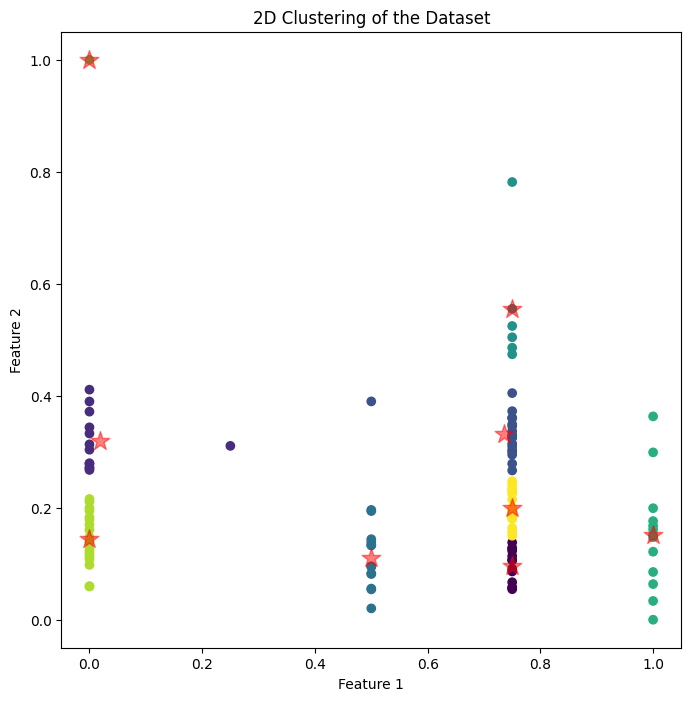

(111,)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium

# Используем данные DataFrame для 2D кластеризации.
data_to_cluster_2d = real_norm_np  # Первые два столбца данных

# 2D Кластеризация с помощью KMeans
k_means_2d = KMeans(init="k-means++", n_clusters=9, n_init=10)
k_means_2d.fit(data_to_cluster_2d)

# Создаем график для 2D кластеризации
plt.figure(figsize=(8, 8))
plt.scatter(data_to_cluster_2d[:, 0], data_to_cluster_2d[:, 1], c=k_means_2d.labels_, cmap='viridis')
plt.scatter(k_means_2d.cluster_centers_[:, 0], k_means_2d.cluster_centers_[:, 1], c='red', s=200, alpha=0.5, marker='*')
plt.title('2D Clustering of the Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

k_means_2d.labels_.shape